# Import modules

In [1]:
import sys #to use files in git_repos folder
sys.path.insert(0,'../')
from atlite.datasets.era5 import retrieve_data, _rename_and_clean_coords, retrieval_times, _area
import atlite
import xarray as xr
import logging
import cdsapi
import geopandas as gpd
import matplotlib.pyplot as plt
from cartopy.io import shapereader
import cartopy.crs as ccrs
import numpy as np
from atlite.datasets.era5 import _rename_and_clean_coords
import pandas as pd
logging.basicConfig(level=logging.INFO)
import os
import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

In [2]:
from functions import natural_earth_shapes_EU, retrieve_roughness

# Retrieve cutout

In [3]:
GCM = 'EC-Earth3' #'MPI-ESM1-2-LR'

climate_model_directory = '/home/com/meenergy/cutouts_cmip6_with_reading_permission/' + GCM
if not os.path.isdir(climate_model_directory):
    os.mkdir(climate_model_directory)

ssp =  'ssp585' # 'ssp370'
variant_label = 'r4i1p1f1' #'r11i1p1f1' 
esgf_params = {
   'data_node': 'esgf-cnr.hpc.cineca.it',
   'source_id': GCM,
   'variant_label':variant_label,
   'experiment_id': ssp,
   'project' : 'CMIP6',
   'frequency':['3hr','6hr','day','mon'],
    }

year = '2032'
dt='3H'

lat_max = 72
lat_min = 32
lon_max = 45
lon_min = -13

coords = {"latmax":lat_max,
          "latmin":lat_min,
          "lonmax":lon_max,
          "lonmin":lon_min}

roughness_year = '2013'

In [4]:
cutout_cmip = atlite.Cutout(path=climate_model_directory + '/Europe_' + GCM + '_' + variant_label + '_ssp' + ssp + '_2032.nc', 
                            module=['cmip'],
                            x=slice(lon_min,lon_max), # European region (longitude boundary)
                            y=slice(lat_min,lat_max), # European region (latitude boundary)
                            time=year,
                            esgf_params=esgf_params,
                            dt=dt, 
                            dx=1, 
                            dy=1)

if GCM != "EC-Earth3":
    cutout_cmip.prepare(features=['wind', 'influx', 'temperature', 'runoff']) # when preparing cutouts other than EC-Earth3
else:
    cutout_cmip.prepare()

print(cutout_cmip.data)
print(cutout_cmip.data.coords)

<xarray.Dataset>
Dimensions:      (x: 59, y: 41, time: 2928)
Coordinates:
  * x            (x) int64 -13 -12 -11 -10 -9 -8 -7 -6 ... 39 40 41 42 43 44 45
  * y            (y) int64 32 33 34 35 36 37 38 39 ... 65 66 67 68 69 70 71 72
  * time         (time) datetime64[ns] 2032-01-01 ... 2032-12-31T21:00:00
    lon          (x) float64 dask.array<chunksize=(59,), meta=np.ndarray>
    lat          (y) float64 dask.array<chunksize=(41,), meta=np.ndarray>
Data variables:
    wnd10m       (time, y, x) float32 dask.array<chunksize=(100, 41, 59), meta=np.ndarray>
    influx       (time, y, x) float32 dask.array<chunksize=(100, 41, 59), meta=np.ndarray>
    outflux      (time, y, x) float32 dask.array<chunksize=(100, 41, 59), meta=np.ndarray>
    temperature  (time, y, x) float32 dask.array<chunksize=(100, 41, 59), meta=np.ndarray>
    runoff       (time, y, x) float32 dask.array<chunksize=(100, 41, 59), meta=np.ndarray>
    wnd100m      (time, y, x) float32 dask.array<chunksize=(100, 41, 59), 

In [5]:
file = "/home/au485969/project/atlite/sandbox_ebbe/data/roughness.nc"
retrieve_roughness(coords,roughness_year,file)
# Create roughness data based on 1 year average from ERA5. 
# Then interpolate the ERA5 data into the resolution of CMIP.
roughness = xr.open_dataset('data/roughness.nc')
roughness = roughness.rename({'fsr':'roughness'})
roughness = roughness.mean(dim='time')
roughness = _rename_and_clean_coords(roughness)
roughness.roughness.attrs['prepared_feature'] = 'wind'
da = roughness.roughness.interp_like(cutout_cmip.data['influx'].isel(time=0))
cutout_cmip.data = cutout_cmip.data.assign(roughness=da)

roughness has already been retrieved


# Convert cutout into wind timeseries

Compare the wind timeseries based on 1) extrapolation of 10 m wind speed based on roughness and 2) interpolation of the wind speed between two heights

In [6]:
cp_wind_w_roughness = cutout_cmip.wind('Vestas_V112_3MW',
                                        model="with_roughness",
                                        from_height = 10,
                                        capacity_factor=True,
                                      )

cp_wind_wo_roughness = cutout_cmip.wind('Vestas_V112_3MW', 
                                        model="without_roughness",
                                        from_height=None,
                                        capacity_factor=True,
                                        )

from_height 10
Calculating wind speed at hub height using 2 wind speed datasets.
from_height 100
from_height2 10


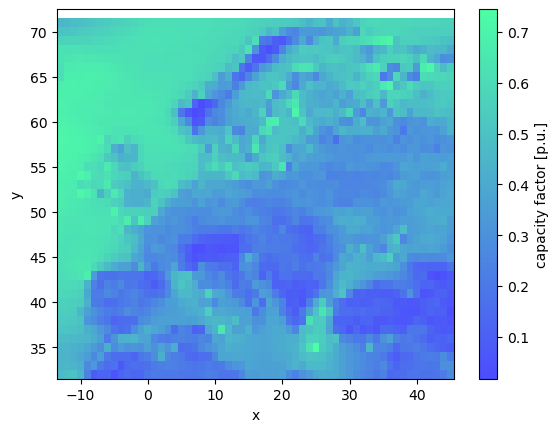

In [7]:
cp_wind_w_roughness.plot(alpha=0.7, cmap='winter');

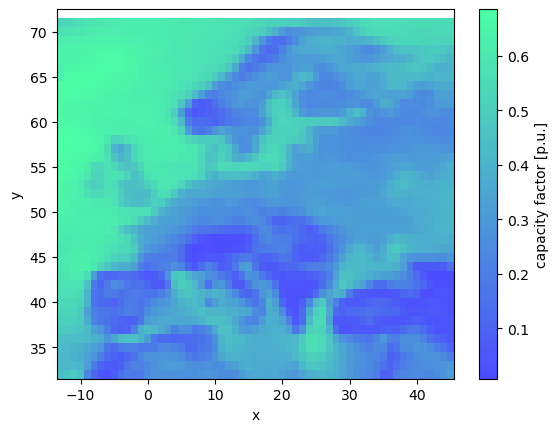

In [8]:
cp_wind_wo_roughness.plot(alpha=0.7, cmap='winter');

In [9]:
# Create Europe shapefile
join_dict = {'FR':['GG','AD','MC'],
             'IT':['VA','SM'], 
             'GB':['JE','IM'],
             'FI':['AX'],
             'DK':['FO'],
             'CH':['LI'], 
             'BE':['LU'],
             'RS':['XK']}
europe = natural_earth_shapes_EU(join_dict)

In [10]:
cp_wind_shape_w_roughness = cutout_cmip.wind('Vestas_V112_3MW', 
                                             model = "with_roughness",
                                             from_height = 10,
                                             shapes=europe,
                                             capacity_factor=True,
                                             per_unit=True
                                            )

from_height 10


In [11]:
cp_wind_shape_wo_roughness = cutout_cmip.wind('Vestas_V112_3MW', 
                                              model="without_roughness",
                                              from_height = None,
                                              shapes=europe,
                                              capacity_factor=True,
                                              per_unit=True
                                              )

Calculating wind speed at hub height using 2 wind speed datasets.
from_height 100
from_height2 10


In [12]:
cp_wind_df_w_r = pd.DataFrame(cp_wind_shape_w_roughness)
cp_wind_df_w_r.columns = cp_wind_shape_w_roughness.coords["dim_0"].data
cp_wind_df_w_r.index = pd.date_range("1/1/2032","1/1/2033",freq="3h")[:-1]

cp_wind_df_wo_r = pd.DataFrame(cp_wind_shape_wo_roughness)
cp_wind_df_wo_r.columns = cp_wind_shape_wo_roughness.coords["dim_0"].data
cp_wind_df_wo_r.index = pd.date_range("1/1/" + year,"1/1/" + str(int(year)+1),freq="3h")[:-1]

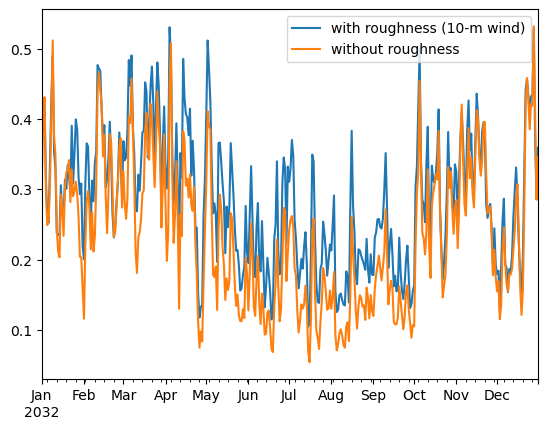

In [13]:
fig, ax = plt.subplots()
cp_wind_df_w_r.mean(axis=1).resample("d").mean().plot(ax=ax, label="with roughness (10-m wind)")
cp_wind_df_wo_r.mean(axis=1).resample("d").mean().plot(ax=ax, label="without roughness")
ax.legend()